# 4. 複数の列を元に列を修正したい（新しい列を作りたい）
ゲーム内アイテム購入データでアイテムの単価が間違っていたので、課金額を修正したいとします。

In [1]:
from itertools import product
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from utilities.process_time import PandasProcessTimeMeasure

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
item_data = pd.read_csv('./data/game_user_item.csv')
item_data.head(5)

,user_id,date,item_id,item_name,item_purchase_count,payment
0,2855,2018-04-14,5,item005,4,6000
1,9634,2018-05-23,4,item004,4,6000
2,5936,2018-05-28,10,item010,4,6000
3,6635,2018-03-08,9,item009,0,0
4,8864,2018-05-27,9,item009,0,0


間違っていたアイテムのIDと正しい単価は下記の通りです。  

|間違っていたアイテムID |正しい単価 |
|:--------------------------|-------------:|
|4                         |360         |
|6                         |1000       |
|7                         |680         |

この情報を元に`item_data`の`payment`を修正する方法について検証します。  
なお、新しい列を追加する場合でも、同じ方法で処理できます。

In [3]:
CORRECT_PRICE_MASTER = {
    4: 360,
    6: 1000,
    7: 680
}

def calculate_correct_payment(item_id, purchase_count, old_payment):
    correct_price = CORRECT_PRICE_MASTER.get(item_id)
    if correct_price is None:
        return old_payment
    new_payment = correct_price * purchase_count
    return new_payment

## 方法1　for文とiterrowsメソッドで値を修正していく

In [4]:
def method1(data):
    _data = data.copy()
    new_payment_list = []
    for i, row in _data.iterrows():
        new_payment = calculate_correct_payment(
            item_id=row.item_id,
            purchase_count=row.item_purchase_count,
            old_payment=row.payment
        )
        new_payment_list.append(new_payment)
    _data.loc[:, 'payment'] = new_payment_list
    return _data

method1(item_data.iloc[:100, :]).head()

,user_id,date,item_id,item_name,item_purchase_count,payment
0,2855,2018-04-14,5,item005,4,6000
1,9634,2018-05-23,4,item004,4,1440
2,5936,2018-05-28,10,item010,4,6000
3,6635,2018-03-08,9,item009,0,0
4,8864,2018-05-27,9,item009,0,0


## 方法2　`apply`メソッドを使う

In [5]:
def method2(data):
    _data = data.copy()
    new_payment = _data.apply(
        func=lambda row: calculate_correct_payment(row.item_id, row.item_purchase_count, row.payment),
        axis=1
    )
    _data.loc[:, 'payment'] = new_payment
    return _data

method2(item_data.iloc[:100, :]).head()

,user_id,date,item_id,item_name,item_purchase_count,payment
0,2855,2018-04-14,5,item005,4,6000
1,9634,2018-05-23,4,item004,4,1440
2,5936,2018-05-28,10,item010,4,6000
3,6635,2018-03-08,9,item009,0,0
4,8864,2018-05-27,9,item009,0,0


## 方法3　必要な列をlistで取り出してfor文で計算する

In [6]:
def method3(data):
    _data = data.copy()
    item_id_list = _data.item_id.tolist()
    item_purchase_count_list = _data.item_purchase_count.tolist()
    payment_list = _data.payment.tolist()
    new_payment_list = []
    for item_id, purchase_count, old_payment in zip(item_id_list, item_purchase_count_list, payment_list):
        new_payment = calculate_correct_payment(item_id, purchase_count, old_payment)
        new_payment_list.append(new_payment)
    _data.loc[:, 'payment'] = new_payment_list
    return _data

method3(item_data.iloc[:100, :]).head()

,user_id,date,item_id,item_name,item_purchase_count,payment
0,2855,2018-04-14,5,item005,4,6000
1,9634,2018-05-23,4,item004,4,1440
2,5936,2018-05-28,10,item010,4,6000
3,6635,2018-03-08,9,item009,0,0
4,8864,2018-05-27,9,item009,0,0


## 検証結果
### 方法1〜3を10万件までのデータで比較
まずは10万件までのデータで比較します。  
方法1は7.7秒、方法2は3.4秒掛かっていますが、方法3は0.1秒未満で終わっています。  
方法1と方法2が遅いのはどちらも内部でDataFrameの操作を行なっているためですが、処理時間に２倍程度の開きが出ている原因については、今後の課題です。

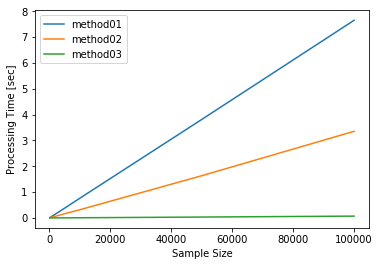

In [9]:
process_time_measure = PandasProcessTimeMeasure(
    data=item_data,
    sample_sizes=[100, 500, 1000, 5000, 10000, 50000, 100000]
)
process_time_measure.set_method(name='method01', method=method1)
process_time_measure.set_method(name='method02', method=method2)
process_time_measure.set_method(name='method03', method=method3)
process_time_measure.measure_process_time_for_each_sample_sizes()
process_time_measure.plot_process_time()

In [10]:
process_time_measure.process_time

,method01,method02,method03
sample_size,,,
100,0.013017,0.004301,0.000694
500,0.040908,0.016684,0.000738
1000,0.076737,0.033213,0.001054
5000,0.380470,0.163058,0.003603
10000,0.765391,0.318527,0.007153
50000,3.813312,1.634766,0.034055
100000,7.651167,3.353313,0.070498


### 方法3を1000万件のデータで検証する
方法3のみ1000万件のデータに適用して、実際の処理時間を検証します。  
結果は6.6秒で完了することができました。  
面倒でもlistに取り出しておくと、すぐに結果を得ることができ、無駄なアイドリングタイムを減らせます。

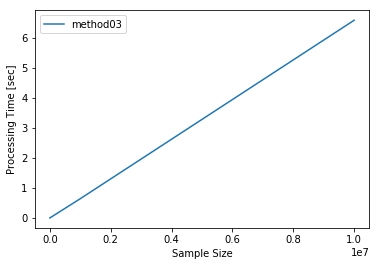

In [11]:
process_time_measure = PandasProcessTimeMeasure(
    data=item_data,
    sample_sizes=[100, 500, 1000, 5000, 10000, 50000, 100000, 1000000, 10000000]
)
process_time_measure.set_method(name='method03', method=method3)
process_time_measure.measure_process_time_for_each_sample_sizes()
process_time_measure.plot_process_time()

In [12]:
process_time_measure.process_time

,method03
sample_size,
100,0.000515
500,0.000741
1000,0.001006
5000,0.003175
10000,0.005870
50000,0.030941
100000,0.062327
1000000,0.640705
10000000,6.596722


## まとめ
ゲーム内アイテム購入データで誤った単価で課金額が計算されている場合を例にして、複数の列を元に既存の列を修正する方法について検証しました。  
その結果、

- 方法1は3つの方法の中で1番遅い
- 方法2は２番目に速く、１番シンプルなコードで記述できる
- 方法3は1番速いが、必要な列をすべてlistに変換する手間が掛かる

が分かりました。  
手間は掛かるものの、方法3は1000万件のデータでも6.6秒で完了するため、繰り返し実行する可能性があるものは、この方法で実装すべきです。  